Image CNN with transfer learning from MobileNETV2 and FCNN head for classification:

Structure/Workflow:

Image ->
MobileNetV2 (pretrained) ->
Global pooled features (1280-d) ->
Projection layer (optional, recommended) ->
Classifier head (FCNN)


Expected Folder Strucure(expand to read):

dataset_root/
├── train/
│   ├── Blue/
│   │   ├── image_001.jpg
│   │   ├── image_002.jpg
│   │   └── ...
│   ├── Green/
│   │   └── ...
│   ├── Black/
│   │   └── ...
│   └── Other/
│       └── ...
├── val/
│   ├── Blue/
│   ├── Green/
│   ├── Black/
│   └── Other/
└── test/
    ├── Blue/
    ├── Green/
    ├── Black/
    └── Other/


Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import os

Device Setup

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


Paths/Parameters/Settings definitions

In [ ]:
BATCH_SIZE = 8
NUM_WORKERS = 2
NUM_CLASSES = 4
EPOCHS = 30
UNFREEZE_EPOCH = 0.8*EPOCHS
INITIAL_LR = 1e-3
FINE_TUNE_LR = 1e-5
SAVE_MODEL_PATH = "best_image_model.pth"
MISCLASS_FILE = "misclassified.txt"
LOSS_PLOT_PATH = "loss_curve.png"
TRAIN_PATH = "dataset/train"
VAL_PATH = "dataset/val"
TEST_PATH = "dataset/test"

Data Transforms

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2), #Optional, will monitor effects.
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])  #Stats need to align with that of MobileNetV2, no stat calculations needed on input data.

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  #Testing data MUST NOT be pre-processed. No rotations/flips/jitter applied.
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


 Datasets and Data-Loaders

In [ ]:
import shutil # Added for removing directories

def remove_ipynb_checkpoints(root_dir):
    if not os.path.exists(root_dir):
        print(f"Warning: Root directory {root_dir} does not exist. Skipping cleanup.")
        return
    for dirpath, dirnames, filenames in os.walk(root_dir):
        if '.ipynb_checkpoints' in dirnames:
            checkpoints_path = os.path.join(dirpath, '.ipynb_checkpoints')
            print(f"Removing .ipynb_checkpoints directory: {checkpoints_path}")
            shutil.rmtree(checkpoints_path)
            # Remove from dirnames so os.walk doesn't try to enter it after deletion
            dirnames.remove('.ipynb_checkpoints')

# Applied as cleanup before creating ImageFolder datasets
remove_ipynb_checkpoints(TRAIN_PATH)
remove_ipynb_checkpoints(VAL_PATH)
remove_ipynb_checkpoints(TEST_PATH)

train_dataset = ImageFolder(root=TRAIN_PATH, transform=train_transform)
val_dataset = ImageFolder(root=VAL_PATH, transform=train_transform)
test_dataset = ImageFolder(root=TEST_PATH, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

#Verifying sizes/dimension
print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))
print("Test samples:", len(test_dataset))

Train samples: 200
Val samples: 205
Test samples: 161


MobileNetV2 Image Encoder Definition

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self, pretrained=True, freeze_backbone=True, proj_dim=256):
        super().__init__()
        self.backbone = models.mobilenet_v2(
            weights=models.MobileNet_V2_Weights.DEFAULT if pretrained else None
        )
        self.backbone.classifier = nn.Identity()  # Remove default classifier, will attach own FCNN head later.

        if freeze_backbone: #Initialize backbone to frozen, but also allows for cluster friendly ONE-TIME submission(instead of manual freeze/unfreeze) setup demonstrated later.
            for param in self.backbone.parameters():
                param.requires_grad = False

        self.feature_dim = 1280  # MobileNetV2 feature output size
        self.projection = nn.Sequential(
            nn.Linear(self.feature_dim, proj_dim),
            nn.BatchNorm1d(proj_dim), #Batch Normalization. Projected dimension is 256, which is the planned size of the text embeddings that will come from the text-based unimodal learning.
            nn.ReLU()
        )

    def forward(self, x):
        features = self.backbone(x) #1280 feature output
        projected = self.projection(features) # linear+normalization+Relu
        return projected# returns processed batch


Image Classifier Definition

In [ ]:
class ImageClassifier(nn.Module):
    def __init__(self, encoder, num_classes=NUM_CLASSES):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Sequential(
          nn.Linear(256, 64),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.Linear(64, num_classes)
        )


    def forward(self, x):
        embeddings = self.encoder(x)
        logits = self.classifier(embeddings)
        return logits

Initialize

In [ ]:
encoder = ImageEncoder(pretrained=True, freeze_backbone=True, proj_dim=256)
model = ImageClassifier(encoder).to(device)

Training Loop Definition: Few words on this part. Initial design was to manually freeze/unfreeze pretrained weights as demonstrated in class, however, due to considerations given to potential need to submit to TALC, such design became infeasible because the possibility of having to submit MULTIPLE jobs and having ANOTHER submission come in between our submissions and I'm unsure how it will affect the model's performance, or can the save point be even accessed correctly if a different request was processed in between. Decision: make the training/validation loop automatically time freeze/unfreeze and process the entire process in 1 submission. In between freeze/unfreeze the optimizer learning rate as well as # of transfer learning epochs will also be tuned to avoid overfit.

In [ ]:
def train_model(model, train_loader, val_loader, device,
                epochs=EPOCHS,               # initial # of epochs used for model initialization
                unfreeze_epoch=UNFREEZE_EPOCH,  # epoch after which the backbone is unfrozen
                initial_lr=INITIAL_LR,       # learning rate before unfreeze
                fine_tune_lr=FINE_TUNE_LR,   # learning rate after unfreeze
                save_path=SAVE_MODEL_PATH):  # file path to save best val-loss model, Saving to FILE may be required, the model will be used later in multi-modal training once combined with text portion.

    # ---- Loss ----
    criterion = nn.CrossEntropyLoss()

    # ---- Initial optimizer: AdamW ----
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=initial_lr,
        weight_decay=1e-4
    )

    train_losses, val_losses = [], []
    best_val_loss = float("inf")

    for epoch in range(epochs):

        # This is how the automatic unfreeze works, once it reaches the defined epoch, backbone unfreezes and AdamW's lr is changed to fine_tune_lr.
        if epoch == unfreeze_epoch:
            print("Unfreezing backbone...")
            for param in model.encoder.backbone.parameters():
                param.requires_grad = True # Unfreeze happens

            # Updating lr in AdamW
            optimizer = torch.optim.AdamW(
                filter(lambda p: p.requires_grad, model.parameters()),
                lr=fine_tune_lr,
                weight_decay=1e-4
            )

        #Training
        model.train()
        running_train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad() #resets gradient between batches
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step() #Steps only after back-propagation
            running_train_loss += loss.item()
        epoch_train_loss = running_train_loss / len(train_loader) #training loss
        train_losses.append(epoch_train_loss)

        #Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad(): #thought this was redundant with model.eval(), but after learning, apparently not.
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
        epoch_val_loss = running_val_loss / len(val_loader) #validation loss
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{epochs} " #Prints losses
              f"Train Loss: {epoch_train_loss:.4f} "
              f"Val Loss: {epoch_val_loss:.4f}")

        # Saving model with smallest val_loss
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), save_path)
            print("Saved best model.")

    return train_losses, val_losses


Full-filling requirements to track misclassified images(Unimodal)

In [ ]:
def evaluate_and_log_errors(model, test_loader, device,
                            save_model_path=SAVE_MODEL_PATH,
                            error_log_file=MISCLASS_FILE):

    model.load_state_dict(torch.load(save_model_path))
    model.eval()

    incorrect_samples = []
    correct, total = 0, 0

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0) #Automatic resizing
            correct += (preds == labels).sum().item()

            # Log misclassified images
            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    dataset_index = batch_idx * test_loader.batch_size + i
                    path, _ = test_loader.dataset.samples[dataset_index]
                    incorrect_samples.append(
                        f"{path} | Pred: {preds[i].item()} | True: {labels[i].item()}"
                    )

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

    with open(error_log_file, "w") as f:
        for line in incorrect_samples:
            f.write(line + "\n")
    print(f"Misclassified samples written to {error_log_file}")
    return accuracy

Loss Curve

In [ ]:
def plot_losses(train_losses, val_losses, save_path=LOSS_PLOT_PATH):
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.savefig(save_path)
    plt.close()
    print(f"Loss curve saved to {save_path}")

Running model

In [ ]:
train_losses, val_losses = train_model(model, train_loader, val_loader, device)
plot_losses(train_losses, val_losses)
accuracy = evaluate_and_log_errors(model, test_loader, device)
imagemodel = model

Epoch 1/30 Train Loss: 1.2863 Val Loss: 1.2244
Saved best model.
Epoch 2/30 Train Loss: 0.9867 Val Loss: 1.0479
Saved best model.
Epoch 3/30 Train Loss: 0.7630 Val Loss: 1.0555
Epoch 4/30 Train Loss: 0.6719 Val Loss: 1.0646
Epoch 5/30 Train Loss: 0.5884 Val Loss: 1.1415
Epoch 6/30 Train Loss: 0.5492 Val Loss: 1.1402
Epoch 7/30 Train Loss: 0.4881 Val Loss: 1.2106
Epoch 8/30 Train Loss: 0.5145 Val Loss: 1.2493
Epoch 9/30 Train Loss: 0.3640 Val Loss: 1.3435
Epoch 10/30 Train Loss: 0.3563 Val Loss: 1.3346
Epoch 11/30 Train Loss: 0.2795 Val Loss: 1.3579
Epoch 12/30 Train Loss: 0.3252 Val Loss: 1.3922
Epoch 13/30 Train Loss: 0.3872 Val Loss: 1.3999
Epoch 14/30 Train Loss: 0.2876 Val Loss: 1.2275
Epoch 15/30 Train Loss: 0.3588 Val Loss: 1.3622
Epoch 16/30 Train Loss: 0.2847 Val Loss: 1.3425
Epoch 17/30 Train Loss: 0.3078 Val Loss: 1.5503
Epoch 18/30 Train Loss: 0.3032 Val Loss: 1.4024
Epoch 19/30 Train Loss: 0.1978 Val Loss: 1.4638
Epoch 20/30 Train Loss: 0.2145 Val Loss: 1.5913
Epoch 21/30 T

Retrieve Image Embeddings for Fusion

In [19]:
def get_image_embeddings(images, model):
    model.eval()
    with torch.no_grad():
        # MobileNetV2 has a .features attribute
        # We pass it through features, then pool it to get a 1D vector
        x = model.features(images)
        x = nn.AdaptiveAvgPool2d(1)(x)
        embeddings = torch.flatten(x, 1)
    return embeddings.cpu().numpy()

Text-based DistillBert Classification:
Uses distilbert-base-uncased

Imports

In [65]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, DistilBertForSequenceClassification
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


Tokenizer+Model

In [66]:

MODEL_NAME = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
base_model = AutoModel.from_pretrained(MODEL_NAME)

base_model = base_model.to(device)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_transform.bias    | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_layer_norm.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Data Extraction

In [43]:
import os
import re
import numpy as np

def read_text_files_with_labels(path):
    texts = []
    labels = []

    class_folders = sorted([
    f for f in os.listdir(path)
    if os.path.isdir(os.path.join(path, f)) and not f.startswith(".")
]) #Avoids hidden files being picked up

    label_map = {class_name: idx for idx, class_name in enumerate(class_folders)}

    for class_name in class_folders:
        class_path = os.path.join(path, class_name)

        if os.path.isdir(class_path):
            file_names = os.listdir(class_path)

            for file_name in file_names:
                file_path = os.path.join(class_path, file_name)

                if os.path.isfile(file_path):
                    # Remove extension
                    file_name_no_ext, _ = os.path.splitext(file_name)

                    # Replace "_" with space
                    text = file_name_no_ext.replace('_', ' ')

                    # Remove digits
                    text_without_digits = re.sub(r'\d+', '', text)

                    texts.append(text_without_digits)
                    labels.append(label_map[class_name])

    return np.array(texts), np.array(labels)


Data Collection

In [44]:
DATA_ROOT = "dataset"

train_texts, train_labels = read_text_files_with_labels(os.path.join(DATA_ROOT, "train"))
val_texts, val_labels = read_text_files_with_labels(os.path.join(DATA_ROOT, "val"))
test_texts, test_labels = read_text_files_with_labels(os.path.join(DATA_ROOT, "test"))

print("Train samples:", len(train_texts))
print("Val samples:", len(val_texts))
print("Test samples:", len(test_texts))

Train samples: 200
Val samples: 205
Test samples: 161


In [37]:
import os

# Define the root dataset folder
dataset_root = "dataset"

# List of subfolders to scan
subfolders = ["train", "val", "test"]

# Collect all class folders across all subfolders
all_class_folders = set()

for subfolder in subfolders:
    path = os.path.join(dataset_root, subfolder)
    # Only include directories that don't start with a dot
    class_folders = [
        f for f in os.listdir(path)
        if os.path.isdir(os.path.join(path, f)) and not f.startswith(".")
    ]
    all_class_folders.update(class_folders)

# Sort class names and create label map
all_class_folders = sorted(all_class_folders)
label_map = {class_name: idx for idx, class_name in enumerate(all_class_folders)}

print("Detected classes and their labels:", label_map)


Detected classes and their labels: {'Black': 0, 'Blue': 1, 'Green': 2, 'Other': 3}


In [48]:
dataset_path = "dataset/test"  # adjust if needed
print(sorted(os.listdir(dataset_path)))

['.DS_Store', 'Black', 'Blue', 'Green', 'Other']


Text Dataset

In [ ]:
MAX_LEN = 500

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=MAX_LEN):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

Data-Loaders

In [70]:

BATCH_SIZE = 16 #Roughly 50 per class in this setup

train_dataset = TextDataset(train_texts, train_labels, tokenizer)
val_dataset   = TextDataset(val_texts, val_labels, tokenizer)
test_dataset  = TextDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Classification Head(with dropout)

In [60]:

class TextClassifier(nn.Module):
    def __init__(self, base_model, num_classes=4):
        super().__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(384, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Use CLS token representation
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # [B, 384]

        x = self.dropout(cls_embedding)
        logits = self.classifier(x)

        return logits

Model Instantiation

In [61]:
num_classes = len(np.unique(train_labels))
print("Detected classes:", num_classes)

model = TextClassifier(base_model, num_classes=num_classes).to(device)

Detected classes: 4


Optimizer + Loss

In [73]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-2)

Training Loop

In [75]:
EPOCHS = 15

train_losses = []
val_losses = []
misclassified_files = []

for epoch in range(EPOCHS):

    # Training

    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)

    # Validation

    model.eval()
    val_loss_total = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            file_names = batch.get("file_name", [None]*labels.size(0))  # fallback if not present

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss_total += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Collecting misclassified file names
            for i in range(len(labels)):
                if preds[i] != labels[i] and file_names[i] is not None:
                    misclassified_files.append(file_names[i])

    val_loss = val_loss_total / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)

    # Logging

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Train Acc:  {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f}")
    print(f"Val Acc:    {val_acc:.4f}")
    print("-" * 40)

Epoch 1/15
Train Loss: 0.1107
Train Acc:  0.9800
Val Loss:   1.2654
Val Acc:    0.6976
----------------------------------------
Epoch 2/15
Train Loss: 0.0965
Train Acc:  0.9900
Val Loss:   1.2804
Val Acc:    0.6732
----------------------------------------
Epoch 3/15
Train Loss: 0.0990
Train Acc:  0.9800
Val Loss:   1.3111
Val Acc:    0.6780
----------------------------------------
Epoch 4/15
Train Loss: 0.1176
Train Acc:  0.9700
Val Loss:   1.2929
Val Acc:    0.6732
----------------------------------------
Epoch 5/15
Train Loss: 0.0959
Train Acc:  0.9750
Val Loss:   1.2862
Val Acc:    0.6878
----------------------------------------
Epoch 6/15
Train Loss: 0.0930
Train Acc:  0.9850
Val Loss:   1.3028
Val Acc:    0.6927
----------------------------------------
Epoch 7/15
Train Loss: 0.0926
Train Acc:  0.9900
Val Loss:   1.4375
Val Acc:    0.6146
----------------------------------------
Epoch 8/15
Train Loss: 0.0968
Train Acc:  0.9800
Val Loss:   1.3579
Val Acc:    0.6537
-----------------

Saving list of misclassified images to file

In [76]:
with open("misclassified.txt", "w") as f:
    for file_name in misclassified_files:
        f.write(f"{file_name}\n")

Loss Chart

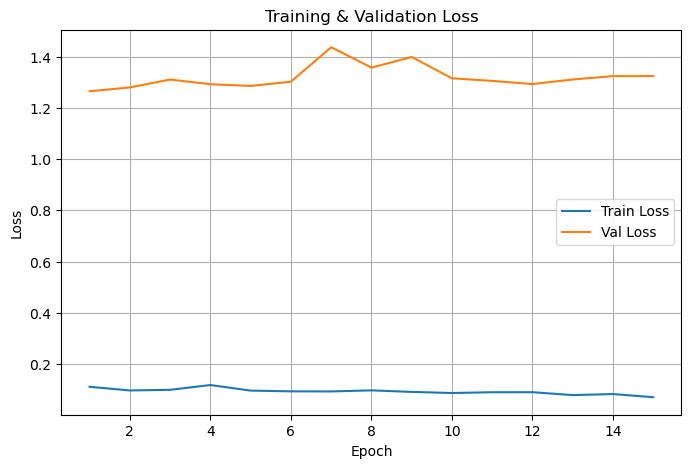

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1, EPOCHS+1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS+1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

Saving Model

In [78]:
torch.save(model.state_dict(), "clean_text_classifier.pth")

In [79]:
def extract_final_text_embeddings(text_list, model_path, tokenizer, base_model):
    """
    text_list : list of strings
    model_path: path to your trained classifier
    tokenizer  : the tokenizer used for DistilBERT
    base_model : the underlying DistilBERT model (without the classifier head)
    """
    # Load the trained classifier
    trained_model = TextClassifier(num_classes=4, base_model=base_model).to(device)
    trained_model.load_state_dict(torch.load(model_path))
    trained_model.eval()

    all_embeddings = []

    with torch.no_grad():
        for text in text_list:
            # Tokenize
            encoding = tokenizer(
                text,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=128
            ).to(device)

            # Pass through the base model only
            outputs = trained_model.base_model(
                input_ids=encoding["input_ids"],
                attention_mask=encoding["attention_mask"]
            )

            # DistilBERT returns last_hidden_state (batch, seq_len, hidden_size)
            # Use [CLS]-like token embedding (first token) or mean pooling
            token_embeddings = outputs.last_hidden_state  # (1, seq_len, hidden_size)
            attention_mask = encoding["attention_mask"]

            # Mean pooling
            mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            sum_embeddings = torch.sum(token_embeddings * mask_expanded, dim=1)
            sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
            embedding = sum_embeddings / sum_mask  # (1, hidden_size)

            all_embeddings.append(embedding.squeeze(0).cpu().numpy())

    return np.array(all_embeddings)
